In [ ]:
! git clone https://github.com/fabianagoes/phd_training.git

In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from tqdm import tqdm
import os
from pathlib import Path
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from itertools import product
from collections import OrderedDict

# Define Models

In [34]:
models = {
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "MLP (Neural Net)": MLPClassifier(max_iter=1000),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

def run_models(Xtrain, Ytrain, Xtest, Ytest):
    acc=[]
    for name in tqdm(models, desc="Training Models"):
        clf = models[name]
        clf.fit(Xtrain,Ytrain)
        y_pred = clf.predict(Xtest)
        acc.append(accuracy_score(Ytest, y_pred))
    return acc

ERROR! Session/line number was not unique in database. History logging moved to new session 34


# One-Hot

In [7]:
def one_hot_encode_sequences(sequences, alphabet="ACGT"):
    """
    One-hot encode sequences and flatten each one.

    Args:
        sequences (list of str): Input sequences.
        alphabet (str or list): Valid characters.

    Returns:
        np.ndarray: Array of shape (num_sequences, seq_len * len(alphabet))
    """
    char_to_index = {char: idx for idx, char in enumerate(alphabet)}
    seq_len = max(len(seq) for seq in sequences)
    num_seqs = len(sequences)
    one_hot = np.zeros((num_seqs, seq_len, len(alphabet)), dtype=int)

    for i, seq in enumerate(sequences):
        for j, char in enumerate(seq.upper()):
            if char in char_to_index:
                one_hot[i, j, char_to_index[char]] = 1

    # Flatten each sequence: (seq_len, len(alphabet)) -> (seq_len * len(alphabet))
    one_hot_flat = one_hot.reshape(num_seqs, -1)
    return one_hot_flat

# K-mers

In [8]:
def generate_kmer_features(sequences, kmax, alphabet="ACGT"):
    """
    Generates k-mer frequency features from a list of sequences.

    Args:
        sequences (list of str): List of nucleotide sequences.
        kmax (int): Maximum size of k-mers to generate.
        alphabet (str): Set of characters allowed in the k-mers (default: "ACGT").

    Returns:
        list of dict: Each dict contains k-mer frequencies for one sequence.
    """
    def get_all_kmers(k, alphabet):
        return [''.join(p) for p in product(alphabet, repeat=k)]

    def count_kmers(seq, k, kmer_template):
        counts = kmer_template.copy()
        total_windows = len(seq) - k + 1
        if total_windows <= 0:
            return {kmer: 0.0 for kmer in kmer_template}  # Handle short sequences
        for i in range(total_windows):
            kmer = seq[i:i+k]
            if kmer in counts:
                counts[kmer] += 1
        return {kmer: count / total_windows for kmer, count in counts.items()}

    all_features = []
    for seq in sequences:
        seq = seq.upper()
        seq_features = OrderedDict()
        for k in range(1, kmax + 1):
            kmer_template = {kmer: 0 for kmer in get_all_kmers(k, alphabet)}
            freqs = count_kmers(seq, k, kmer_template)
            seq_features.update(freqs)
        all_features.append(seq_features)
    
    return all_features

# G-C Content

In [9]:
def gc_content_features(sequences):
    """
    Computes GC content and related features for a list of sequences.

    Args:
        sequences (list of str): List of nucleotide sequences.

    Returns:
        list of dict: Each dict contains GC features for one sequence.
    """
    features = []
    for seq in sequences:
        seq = seq.upper()
        g = seq.count("G")
        c = seq.count("C")
        gc = g + c
        length = len(seq)
        gc_ratio = gc / length if length > 0 else 0
        features.append({
            "GC_Content": gc_ratio,
            "G_Count": g,
            "C_Count": c,
            "Length": length
        })
    return features

# Chaos Game Representations

In [10]:
def classifical_chaos_features(sequences, max_length):
    """
    Computes Classifical Chaos Game Representation (CGR) features for each sequence.

    Args:
        sequences (list of str): List of nucleotide sequences.
        max_length (int): Padding target length for sequences.

    Returns:
        list of np.ndarray: Each array contains CGR features (padded) for a sequence.
    """
    features = []

    for seq in sequences:
        seq = seq.upper()
        Sx, Sy = [], []

        for nucle in seq:
            if nucle == "A":
                Sx.append(1)
                Sy.append(1)
            elif nucle == "C":
                Sx.append(-1)
                Sy.append(-1)
            elif nucle in ["T", "U"]:
                Sx.append(-1)
                Sy.append(1)
            else:  # G or unknown
                Sx.append(1)
                Sy.append(-1)

        CGR_x = []
        CGR_y = []

        for i in range(len(Sx)):
            if i == 0:
                CGR_x.append(0.5 * Sx[i])
                CGR_y.append(0.5 * Sy[i])
            else:
                CGR_x.append(0.5 * Sx[i] + 0.5 * CGR_x[i - 1])
                CGR_y.append(0.5 * Sy[i] + 0.5 * CGR_y[i - 1])

        concat = CGR_x + CGR_y
        padded = np.pad(concat, (0, 2 * (max_length - len(seq))), 'constant')
        features.append(padded)

    return features

# Load Data

In [11]:
path = ######### GIVE PATH ###########
print('Dataset Selected: ', path)

train_data=pd.read_csv(path+'/train.csv')
val_data=pd.read_csv(path+'/dev.csv')
test_data=pd.read_csv(path+'/test.csv')
data={'Train':train_data,'Val':val_data,'Test':test_data}

train_data.head(5)

Dataset Selected:  datasets/GUE/EMP/H3


,sequence,label
0,CTGAAATTTTTTTCGTTTCGCCACCAAGAAAGGCTAATTGAATACA...,1
1,ATATGCTCGAAAATGTAGCTATATTTCACGGATGAATAACTCGTAA...,0
2,CAACGGTACCCAATGGTTCCATCTCTAAGTCGTTAGGGCCAATCGT...,1
3,AACGAAGTCTAAATGGATCGAAGAAAGATTTCAAGAAAAGGTAAGT...,0
4,TGAGCAAATTTCCTTCCAACTTAGATGAACCCAGTAATTTTATTAA...,0


# Load Labels

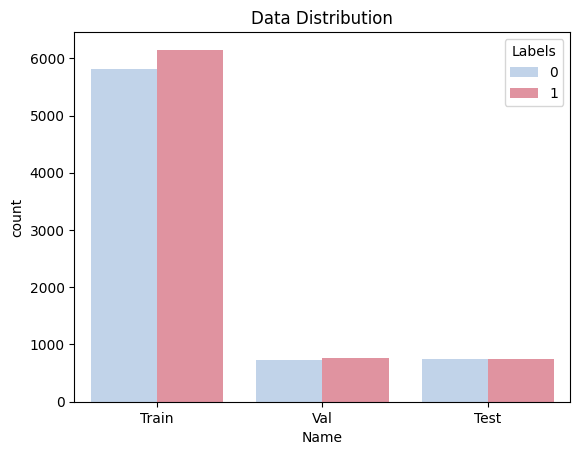

In [17]:
labels=[]
dataname=[]
colors=['#BAD2F0', '#ED8697']
for d in data:
    labels.extend((data[d])['label'])
    dataname.extend([d]*len(data[d].index))

label_distr=pd.DataFrame({'Labels':labels,'Name':dataname})
label_distr.reset_index() 

sns.countplot(label_distr,x='Name',hue='Labels',palette=colors)
plt.title('Data Distribution')
plt.show()

# Extract Sequences

In [18]:
sequences={}

for d in data:
    sequences[d]=(data[d])[######## SELECT THE RIGHT COLUMN #########]

pd.DataFrame(sequences).head(5)

,Train,Val,Test
0,CTGAAATTTTTTTCGTTTCGCCACCAAGAAAGGCTAATTGAATACA...,ACAATAATAATAATAATAATAATAATAATAACAATAACAATAGTGG...,TCGGTATGCGTTTCCAGAGAGAAGTTGTCGTCTAACTTCACGCCTG...
1,ATATGCTCGAAAATGTAGCTATATTTCACGGATGAATAACTCGTAA...,CCAAACCAACTTAGAACAATGCACCCAGTTTTTTTTCAGATTGATT...,TAAACCAAGCGTAAATCAGTATTGCTCTTACCGCAGTAGGGGGAGT...
2,CAACGGTACCCAATGGTTCCATCTCTAAGTCGTTAGGGCCAATCGT...,GCCTTGTATGCCATCCAAATTTTTGATTTCTTATGGTTCCCTTGGT...,AACTCTTCAAAAGAAATTCCTCAAATATGTCCAGTTTCATGTACTG...
3,AACGAAGTCTAAATGGATCGAAGAAAGATTTCAAGAAAAGGTAAGT...,GCATTCAGAGGGTGTGGATGATTGGGGTGCCGTTAAGTATTTATAT...,AAGGTTTTTCAAAGGATACATTTGAATTGATCAAGACATTTTTAGT...
4,TGAGCAAATTTCCTTCCAACTTAGATGAACCCAGTAATTTTATTAA...,GATATCTCAAGTGGGCAATACCCATGGAACCAGCAAGACCGGAAAC...,TCCTTCAAGAACTTAGCAAGAAGTACCAATTAGTCCCAGCGGGCCC...


In [21]:
max_length=len(train_data['sequence'][0]) 
max_length

500

# Extract One-hot Encodings

In [19]:
one_hot_feat=pd.DataFrame()
for seq_set in sequences:
    one_hot_feat=pd.concat([one_hot_feat,pd.DataFrame(one_hot_encode_sequences(sequences[seq_set]))],ignore_index=True)
one_hot_feat.head(5)

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,1,0,0
1,1,0,0,0,0,0,0,1,1,0,...,0,1,0,1,0,0,1,0,0,0
2,0,1,0,0,1,0,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0
3,1,0,0,0,1,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
4,0,0,0,1,0,0,1,0,1,0,...,0,1,1,0,0,0,0,0,0,1


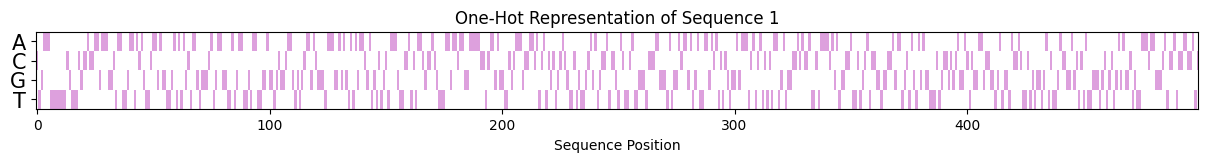

In [24]:
row = np.asarray(one_hot_feat.iloc[0])
image_2d = row.reshape((max_length, 4)).T
plum_colormap = ListedColormap(['white', '#DDA0DD'])
plt.figure(figsize=(15,1))
plt.imshow(image_2d, interpolation='nearest', aspect='auto',cmap=plum_colormap)
plt.yticks([0,1,2,3], ['A','C','G','T'],size=15)
plt.xlabel("Sequence Position")
plt.title("One-Hot Representation of Sequence 1")
plt.show()

# Extract K-mers

In [27]:
kmer_feat=pd.DataFrame()
for seq_set in sequences:
    kmer_feat=pd.concat([kmer_feat,pd.DataFrame(generate_kmer_features(sequences[seq_set],####### USE A K VALUE #######))],ignore_index=True)
kmer_feat.head(5)

,A,C,G,T,AA,AC,AG,AT,CA,CC,...,TTCG,TTCT,TTGA,TTGC,TTGG,TTGT,TTTA,TTTC,TTTG,TTTT
0,0.284,0.210,0.258,0.248,0.092184,0.044088,0.074148,0.074148,0.076152,0.044088,...,0.006036,0.010060,0.006036,0.002012,0.006036,0.002012,0.002012,0.006036,0.000000,0.008048
1,0.372,0.164,0.192,0.272,0.162325,0.048096,0.058116,0.102204,0.068136,0.014028,...,0.004024,0.002012,0.004024,0.000000,0.006036,0.002012,0.002012,0.006036,0.004024,0.006036
2,0.310,0.208,0.224,0.258,0.124248,0.056112,0.056112,0.072144,0.076152,0.058116,...,0.004024,0.000000,0.006036,0.000000,0.006036,0.008048,0.006036,0.000000,0.002012,0.006036
3,0.378,0.156,0.188,0.278,0.146293,0.056112,0.082164,0.094188,0.064128,0.024048,...,0.002012,0.008048,0.008048,0.002012,0.002012,0.004024,0.008048,0.008048,0.002012,0.012072
4,0.332,0.154,0.192,0.322,0.124248,0.042084,0.066132,0.100200,0.042084,0.032064,...,0.004024,0.006036,0.004024,0.004024,0.010060,0.010060,0.004024,0.006036,0.010060,0.006036


In [28]:
kmer_feat.iloc[0].rename('K-mer Percentage for Seq 1').head(10)

A     0.284000
C     0.210000
G     0.258000
T     0.248000
AA    0.092184
AC    0.044088
AG    0.074148
AT    0.074148
CA    0.076152
CC    0.044088
Name: K-mer Percentage for Seq 1, dtype: float64

# Get GC Content

In [29]:
gc_feat=pd.DataFrame()
for seq_set in sequences:
    gc_feat=pd.concat([gc_feat,pd.DataFrame(gc_content_features(sequences[seq_set]))],ignore_index=True)
print('GC Content')
gc_feat.head(5)

GC Content


,GC_Content,G_Count,C_Count,Length
0,0.468,129,105,500
1,0.356,96,82,500
2,0.432,112,104,500
3,0.344,94,78,500
4,0.346,96,77,500


# Get GCR Features

In [30]:
cgr_feat=pd.DataFrame()
for seq_set in sequences:
    cgr_feat=pd.concat([cgr_feat,pd.DataFrame(classifical_chaos_features(sequences[seq_set],max_length))],ignore_index=True)
cgr_feat.head(5)

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,-0.5,-0.75,0.125,0.5625,0.78125,0.890625,-0.054688,-0.527344,-0.763672,-0.881836,...,0.595453,-0.202273,-0.601137,0.199432,0.599716,-0.200142,-0.600071,0.199964,0.599982,-0.200009
1,0.5,-0.25,0.375,-0.3125,0.34375,-0.328125,-0.664062,-0.832031,0.083984,0.541992,...,-0.165067,-0.582534,-0.791267,-0.895633,0.052183,-0.473908,-0.736954,0.131523,-0.434239,0.282881
2,-0.5,0.25,0.625,-0.1875,0.40625,0.703125,-0.148438,0.425781,-0.287109,-0.643555,...,0.483972,-0.258014,-0.629007,0.185497,-0.407252,0.296374,0.648187,0.824094,0.912047,0.956023
3,0.5,0.75,-0.125,0.4375,0.71875,0.859375,0.929688,-0.035156,-0.517578,-0.758789,...,0.616153,0.808076,-0.095962,0.452019,-0.273990,-0.636995,-0.818498,0.090751,0.545376,0.772688
4,-0.5,0.25,0.625,0.8125,-0.09375,0.453125,0.726562,0.863281,-0.068359,-0.534180,...,0.343174,-0.328413,0.335794,-0.332103,0.333948,0.666974,0.833487,0.916744,0.958372,0.979186


Text(0.5, 1.0, 'Chaos game Representation for Sequence 1')

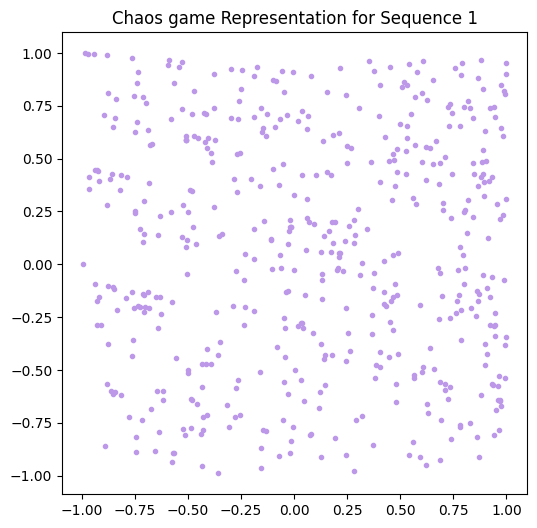

In [31]:
CGR_x=cgr_feat.iloc[0,:max_length]
CGR_y=cgr_feat.iloc[0,max_length:]
plt.figure(figsize=(6, 6))
plt.scatter(CGR_x, CGR_y, marker='.',color='#BD98E9')
plt.title(f"Chaos game Representation for Sequence 1")


# Test Each Representation Against 5 Models and Compare

Training Models: 100%|████████████████████████████████████████████████████████████████████████████████| 2/2 [02:44<00:00, 82.11s/it]


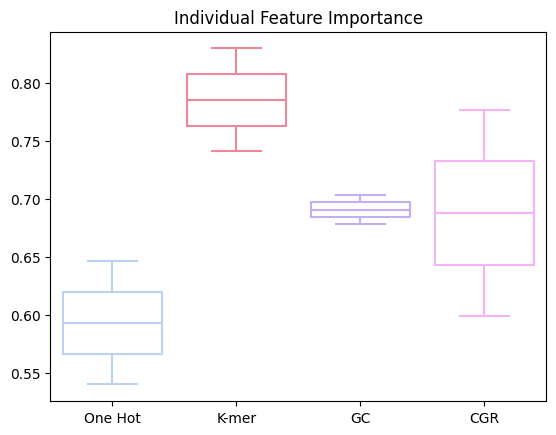

In [35]:
feats=[one_hot_feat,kmer_feat,gc_feat,cgr_feat]
accuracy={}
feat_names=['One Hot','K-mer','GC','CGR']
colors = ['#BAD2F0', '#ED8697', '#C2AEF2', '#F5B2F4', ]

for feat_ind in range(0,4):
    feat=(feats[feat_ind]).fillna(0)
    train_feats=feat[label_distr['Name']=='Train']
    test_feats=feat[label_distr['Name']== ####### EXTRACT TEST COLUMN ########]
    train_labels=label_distr[label_distr['Name']=='Train']['Labels']
    ####### EXTRACT TEST LABELS ########
    accuracy[feat_names[feat_ind]]=run_models(train_feats,train_labels,test_feats,test_labels)

sns.boxplot(accuracy, fill=False, palette=colors)
plt.title('Individual Feature Importance')
plt.show()
